#### Tree Questions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import statsmodels.api as sm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR, 
                          plot_tree, 
                          export_text)
from sklearn.ensemble import (RandomForestClassifier as RFC,GradientBoostingRegressor as GBR, RandomForestRegressor as RF)
from sklearn.metrics import (accuracy_score, 
                             log_loss)
from ISLP.bart import BART
from mpl_toolkits.mplot3d import Axes3D


#### Question 1
- Random Forest on `maxFeatures` & `n_estimators`

In [ ]:
data = load_data('Boston')
x = data.drop(columns='medv')
y = data['medv']
x = sm.add_constant(x)

cv = skm.ShuffleSplit(n_splits = 5, test_size = 0.2, random_state=0)

# Range of values
max_features = np.arange(1, x.shape[1] + 1)
estimators = np.arange(100,1500, 100)
rss_vals = np.zeros((len(max_features), len(estimators)))

for features in max_features : 
    for estimator in estimators : 
        for train_idx, test_idx in cv.split(x) : 
            x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
            x_test, y_test = x.iloc[test_idx], y.iloc[test_idx]
            
            # Fitting
            rf = RF(n_estimators=estimator, max_features=features)
            rf.fit(x_train, y_train)
            y_pred = rf.predict(x_test)
            rss_vals[features-1, estimator//100 - 1] += ((y_pred - y_test) ** 2).sum()

        rss_vals[features-1, estimator//100 - 1] /= cv.get_n_splits()
        print(f"Testing Done for {features} features and {estimator} estimators")

Testing Done for 1 features and 100 estimators
Testing Done for 1 features and 200 estimators
Testing Done for 1 features and 300 estimators
Testing Done for 1 features and 400 estimators
Testing Done for 1 features and 500 estimators
Testing Done for 1 features and 600 estimators
Testing Done for 1 features and 700 estimators
Testing Done for 1 features and 800 estimators
Testing Done for 1 features and 900 estimators
Testing Done for 1 features and 1000 estimators
Testing Done for 1 features and 1100 estimators
Testing Done for 1 features and 1200 estimators
Testing Done for 1 features and 1300 estimators
Testing Done for 1 features and 1400 estimators
Testing Done for 2 features and 100 estimators
Testing Done for 2 features and 200 estimators
Testing Done for 2 features and 300 estimators
Testing Done for 2 features and 400 estimators
Testing Done for 2 features and 500 estimators
Testing Done for 2 features and 600 estimators
Testing Done for 2 features and 700 estimators
Testing 

In [ ]:
import plotly.graph_objects as go

# Create meshgrid for 3D surface
X, Y = np.meshgrid(estimators, max_features)

# Create interactive 3D surface plot
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=rss_vals)])

# Update layout
fig.update_layout(
    title='Interactive 3D Visualization of RSS Values',
    scene=dict(
        xaxis_title='Number of Estimators',
        yaxis_title='Number of Features',
        zaxis_title='RSS Value'
    ),
    width=1000,
    height=800
)

# Add hover template
fig.update_traces(hovertemplate='Estimators: %{x}<br>Features: %{y}<br>RSS: %{z}<extra></extra>')

# Add download buttons
fig.show(config={'toImageButtonOptions': {'format': 'png', 'filename': 'rss_3d_plot'},
                'displaylogo': False,
                'modeBarButtonsToAdd':['downloadhtml']})

#### Question 2
- Carseats dataset and use `Sales` as quantitative response variable

In [ ]:
data = load_data('Carseats')
cv = skm.ShuffleSplit(n_splits = 1, test_size = 0.3, random_state=0)
x = data.drop(columns='Sales')
x["Urban"]  = np.where(x["Urban"] == "Yes", 1, 0)
x["US"]  = np.where(x["US"] == "Yes", 1, 0)
x = pd.get_dummies(x, drop_first=True)
x["ShelveLoc_Good"] = np.where(x["ShelveLoc_Good"] == "True", 1, 0)
x["ShelveLoc_Medium"] = np.where(x["ShelveLoc_Medium"] == "True", 1, 0)
y = data['Sales']
x = sm.add_constant(x)
x.head()

,const,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Medium
0,1.0,138,73,11,276,120,42,17,1,1,0,0
1,1.0,111,48,16,260,83,65,10,1,1,0,0
2,1.0,113,35,10,269,80,59,12,1,1,0,0
3,1.0,117,100,4,466,97,55,14,1,1,0,0
4,1.0,141,64,3,340,128,38,13,1,0,0,0


In [ ]:
train_idx, test_idx = next(cv.split(x))
x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
y_test = y.iloc[test_idx]
x_test = x.iloc[test_idx]

# Fitting
max_depth = np.arange(1, 11)

for depth in max_depth : 
    dt = DTR(max_depth=depth)
    dt.fit(x_train, y_train)
    y_pred = dt.predict(x_test)
    rss = np.mean((y_pred - y_test) ** 2)
    print(f"RSS for depth {depth} : {rss}")



RSS for depth 1 : 6.193522783011738
RSS for depth 2 : 5.97078216899392
RSS for depth 3 : 6.1541232235938805
RSS for depth 4 : 6.466964057087536
RSS for depth 5 : 6.809382007542687
RSS for depth 6 : 6.811311018281704
RSS for depth 7 : 7.632459660713405
RSS for depth 8 : 7.6080910750038315
RSS for depth 9 : 8.37708896379846
RSS for depth 10 : 8.334771772845556


We will be going with `depth` = 2. Test MSE is around 5.97.

In [ ]:
# Tree Pruning
dt = DTR(max_depth=2)
pruning = dt.cost_complexity_pruning_path(x_train, y_train)
kfold = skm.ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
alpha = pruning.ccp_alphas
grid = skm.GridSearchCV(dt, {"ccp_alpha": alpha}, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(x, y)
print(f"Best alpha : {grid.best_params_}")
print(f"Best RSS : {-grid.best_score_}")

Best alpha : {'ccp_alpha': 0.38799268596327363}
Best RSS : 6.306024924121663


Tree pruning doesn't help to improve the RSS, it does definetly worsen it.

In [ ]:
# Bagging
estimators = np.arange(100, 1000, 100)

for estimator in estimators : 
    bag = RF(n_estimators=estimator, max_features=x.shape[1])
    bag.fit(x_train, y_train)
    y_pred = bag.predict(x_test)
    rss = np.mean((y_pred - y_test) ** 2)
    print(f"RSS for {estimator} estimators : {rss}")

# 300 Estimators seems to be the right one



RSS for 100 estimators : 4.971652086583333
RSS for 200 estimators : 4.896542191854168
RSS for 300 estimators : 4.8445321301574085
RSS for 400 estimators : 4.873734201114583
RSS for 500 estimators : 4.845313934490006
RSS for 600 estimators : 4.853444127965285
RSS for 700 estimators : 4.90065623661395
RSS for 800 estimators : 4.875421623429694
RSS for 900 estimators : 4.873433630335399


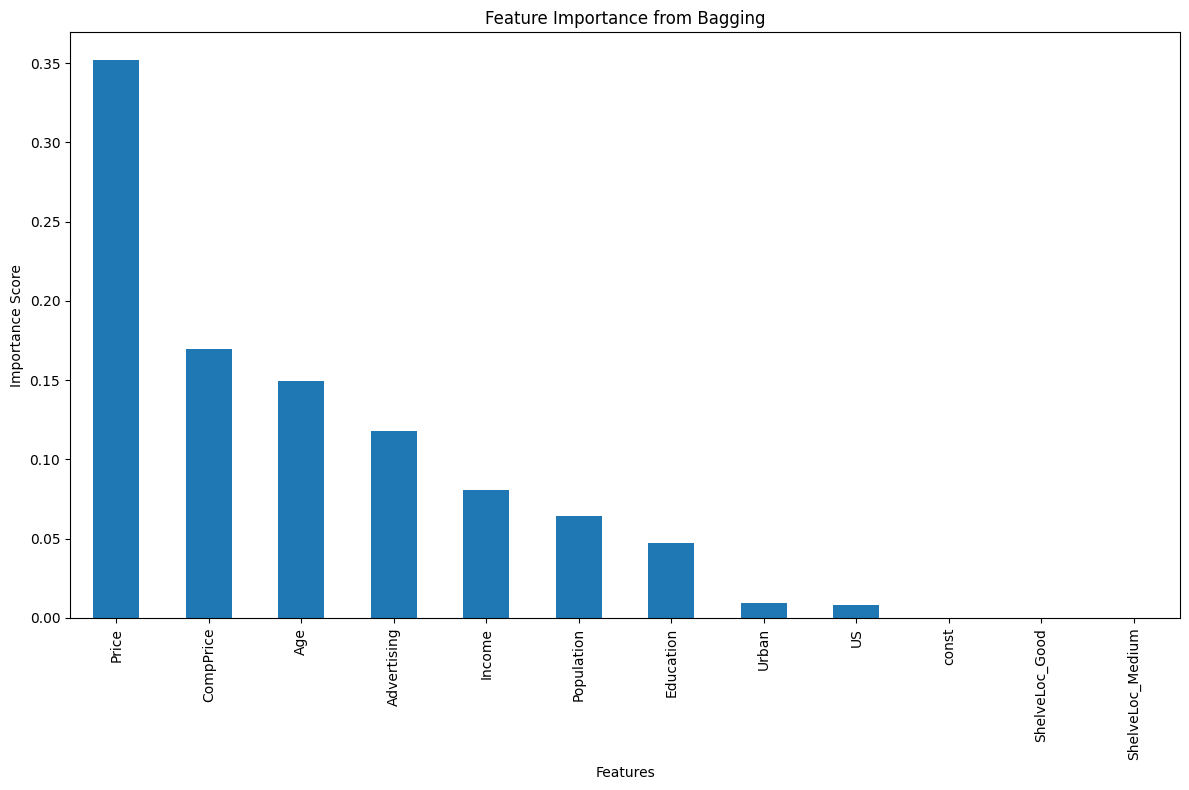

In [ ]:
# Feature Importance
bag = RF(n_estimators=300, max_features=x.shape[1])
bag.fit(x_train, y_train)
importance = bag.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Bagging')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

RSS for Random Forest : 4.761317981314814


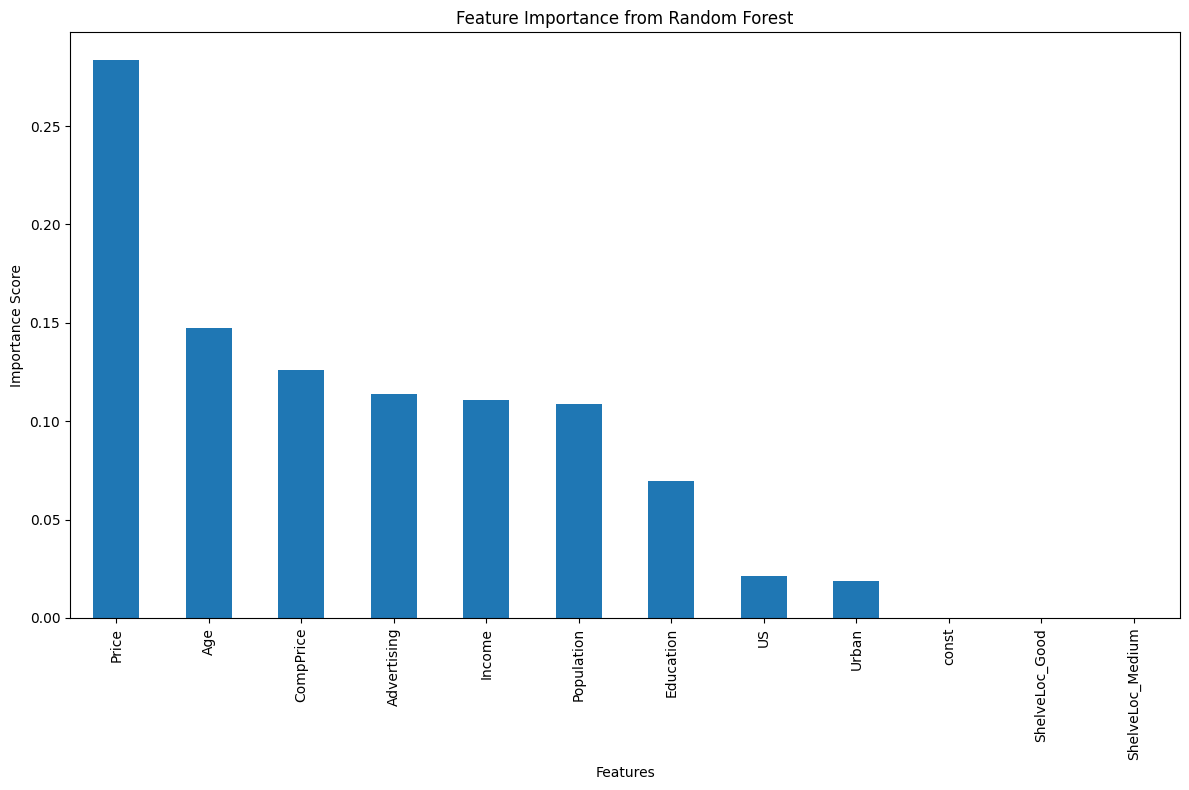

In [ ]:
# Random Forest
max_feat = int(np.sqrt(x.shape[1]))
rf = RF(n_estimators=300, max_features=max_feat)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"RSS for Random Forest : {rss}")

# Feature Importance
importance = rf.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

RSS for Gradient Boosting : 4.966749337466965


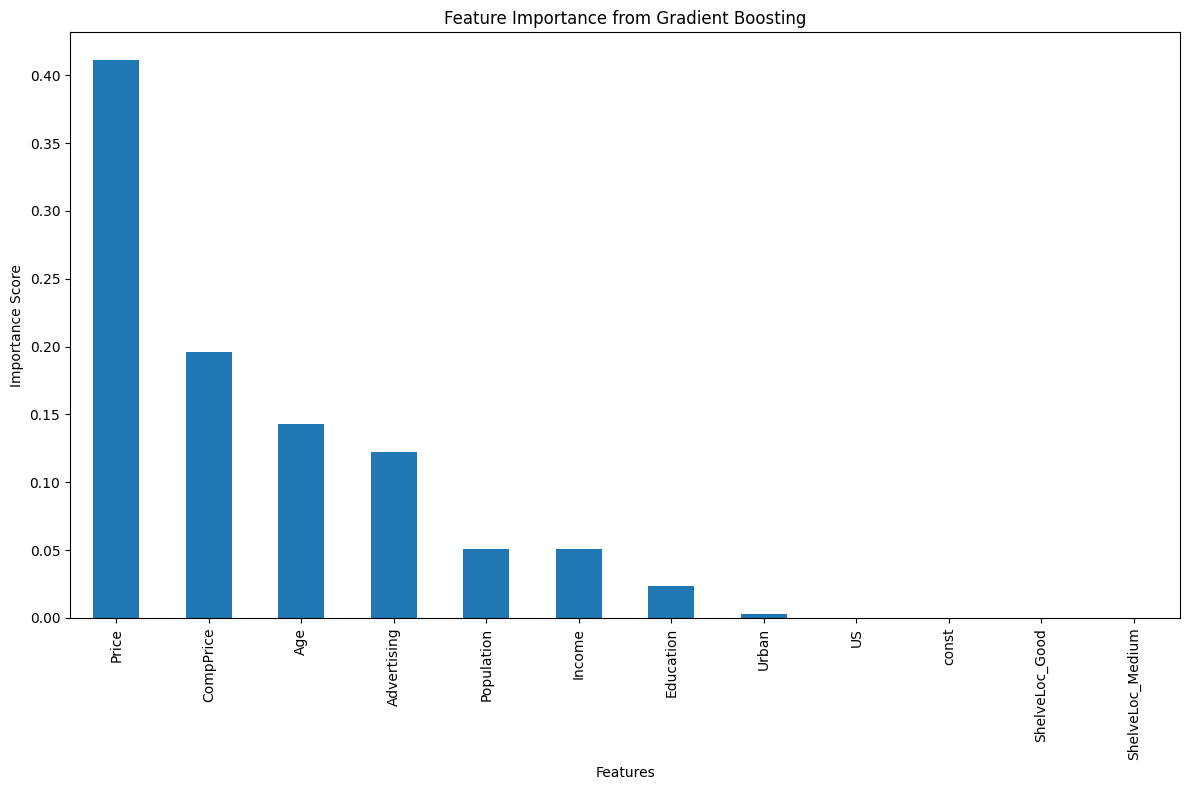

In [ ]:
# Gradient Boosting
gb = GBR(n_estimators=300, learning_rate=0.03, max_depth=max_feat, random_state=0)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"RSS for Gradient Boosting : {rss}")

# Feature Importance
importance = gb.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


RSS for BART : 4.085473266888379


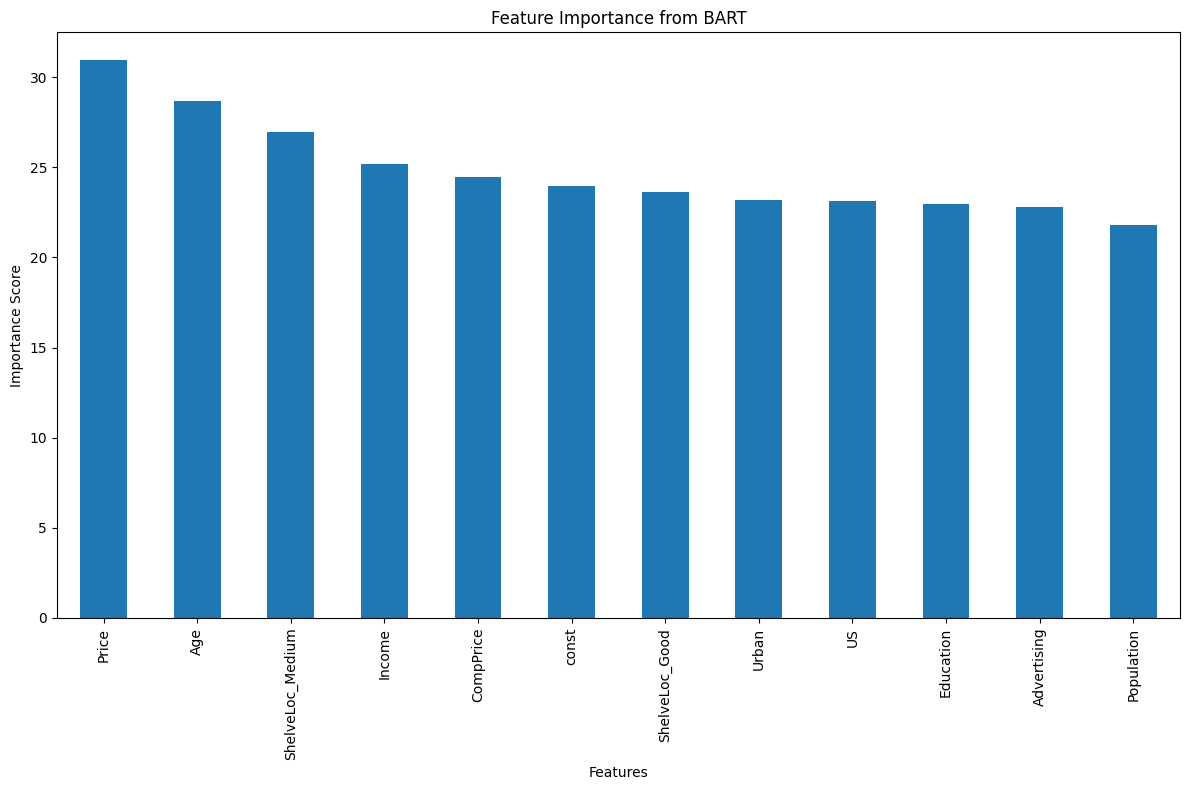

In [ ]:
# BART
bart = BART(burnin=5, ndraw=15, random_state=0)
bart.fit(x_train, y_train)
y_pred = bart.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"RSS for BART : {rss}")

# Feature Importance
importance = bart.variable_inclusion_.mean(0)
var = pd.Series(importance, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
var.plot(kind='bar')
plt.title('Feature Importance from BART')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

Some how BART performs better than Random Forest, Gradient Boosting and Other methods. Need to learn how does it do it and what is happening in the hood because for an ensemble method it is very powerful then.

In [ ]:
data = load_data('OJ')
data.head()



,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [ ]:
cv = skm.ShuffleSplit(n_splits = 1, test_size = 278, random_state=0)
x = data.drop(columns='Purchase')
x["Store7"]  = np.where(x["Store7"] == "Yes", 1, 0)
y = data['Purchase']
y = np.where(y == "CH", 1, 0)

train_idx, test_idx = next(cv.split(x))
x_train, y_train = x.iloc[train_idx], y[train_idx]
y_test = y[test_idx]
x_test = x.iloc[test_idx]


In [ ]:
depth = np.arange(2,7)

for d in depth : 
    dt = DTC(max_depth=d, criterion="entropy")
    dt.fit(x_train, y_train)
    y_pred = dt.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for depth {d} : {acc}")
    
    print("\n")

# Seems like depth 3 is the best one.

dt = DTC(max_depth=3)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
confusion = confusion_table(y_test, y_pred)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Log Loss : {log_loss(y_test, y_pred)}")


Accuracy for depth 2 : 0.7913669064748201


Accuracy for depth 3 : 0.8129496402877698


Accuracy for depth 4 : 0.7733812949640287


Accuracy for depth 5 : 0.7661870503597122


Accuracy for depth 6 : 0.7841726618705036


Accuracy : 0.8129496402877698
Log Loss : 6.741978331777309


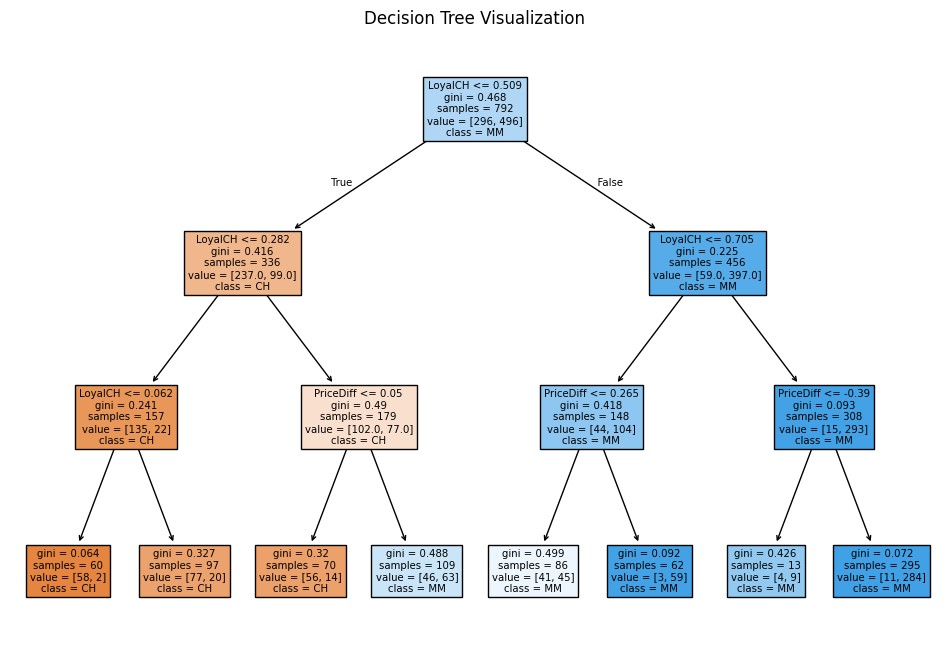

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, feature_names=x.columns, class_names=["CH", "MM"], filled=True, ax=ax)
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
print(export_text(dt, feature_names=list(x.columns), class_names = ["CH", "MM"]))
dt.tree_.n_leaves

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- class: CH
|   |   |--- LoyalCH >  0.06
|   |   |   |--- class: CH
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- class: CH
|   |   |--- PriceDiff >  0.05
|   |   |   |--- class: MM
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.27
|   |   |   |--- class: MM
|   |   |--- PriceDiff >  0.27
|   |   |   |--- class: MM
|   |--- LoyalCH >  0.71
|   |   |--- PriceDiff <= -0.39
|   |   |   |--- class: MM
|   |   |--- PriceDiff >  -0.39
|   |   |   |--- class: MM



8

The tree is very short and doesn't have much leaves, focus on only 2 parameters accurately identified.  Something like loyalCH and PriceDiff which totally makes sense.

In [ ]:
ccp = dt.cost_complexity_pruning_path(x,y)
alpha = ccp.ccp_alphas
cv = skm.ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
gridcv = skm.GridSearchCV(dt, {"ccp_alpha": alpha}, cv=cv, scoring='accuracy')
gridcv.fit(x, y)

print(f"Best alpha : {gridcv.best_params_}")
print(f"Best accuracy : {gridcv.best_score_}")
print(f"Best depth : {gridcv.best_estimator_.tree_.max_depth}")
print(f"Best number of leaves : {gridcv.best_estimator_.tree_.n_leaves}")
print(f"Best number of nodes : {gridcv.best_estimator_.tree_.node_count}")
print(f"Best number of features : {gridcv.best_estimator_.n_features_in_}")
print(f"Best number of classes : {gridcv.best_estimator_.n_classes_}")
print(export_text(gridcv.best_estimator_, feature_names=list(x.columns), class_names = ["CH", "MM"]))

Best alpha : {'ccp_alpha': 0.01206214336701894}
Best accuracy : 0.8373831775700935
Best depth : 3
Best number of leaves : 4
Best number of nodes : 7
Best number of features : 17
Best number of classes : 2
|--- LoyalCH <= 0.48
|   |--- class: CH
|--- LoyalCH >  0.48
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.01
|   |   |   |--- class: CH
|   |   |--- PriceDiff >  0.01
|   |   |   |--- class: MM
|   |--- LoyalCH >  0.71
|   |   |--- class: MM



Not going to say but pruning helped a lot while improving the accuracy. Cut down the leaves from 8 to 4 while getting a better accuracy on KFold.

#### Question 4
- Boosting to predict Salary in Hitters DataSet

In [2]:
data = load_data('Hitters')
data = data.dropna()

data.shape

(263, 20)

In [3]:
data.head()
design = MS(data.columns.drop('Salary'))
x = design.fit_transform(data)
y = data['Salary']

cv = skm.ShuffleSplit(n_splits = 1, test_size = 0.25, random_state=0)

train_idx, test_idx = next(cv.split(x))
x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
y_test = y.iloc[test_idx]
x_test = x.iloc[test_idx]


In [7]:
# Log Transformation
y_train, y_test = np.log(y_train), np.log(y_test)

learning_rate = np.linspace(0.001,0.04)
train_mse = np.zeros(learning_rate.shape[0])

for i, lr in enumerate(learning_rate) :
    gb = GBR(n_estimators=1000, learning_rate=lr, random_state=0)
    gb.fit(x_train, y_train)
    y_pred = gb.predict(x_test)
    train_mse[i] = np.mean((y_pred - y_test) ** 2)

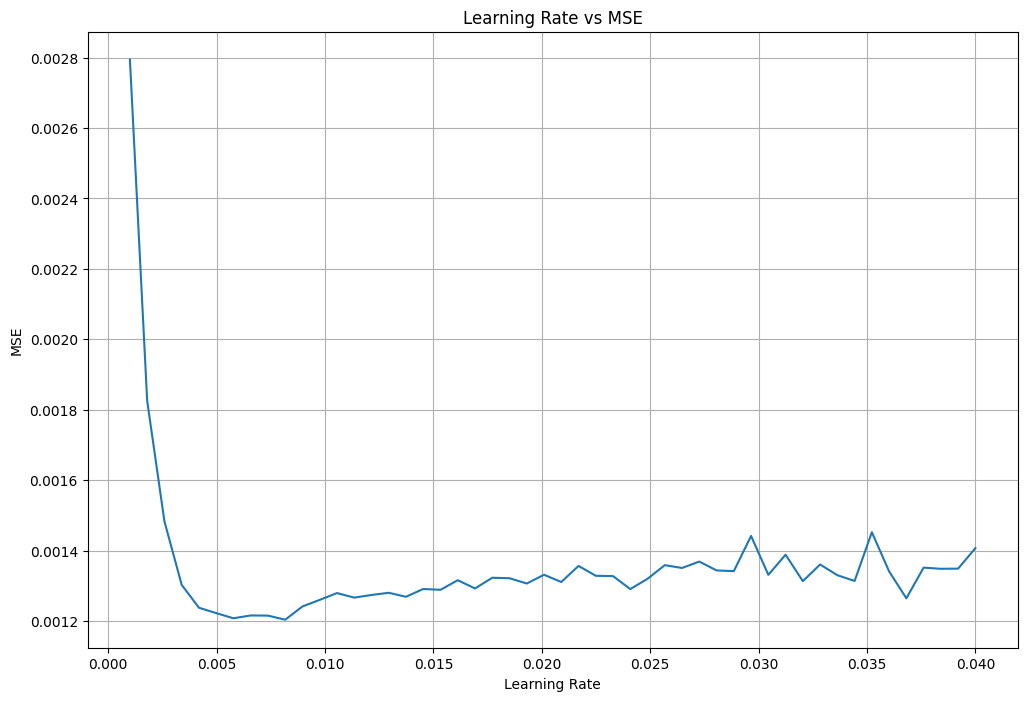

In [11]:
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(learning_rate, train_mse)
plt.title('Learning Rate vs MSE')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [13]:
best_GBR = GBR(n_estimators=1000, learning_rate=0.00816326530612245, random_state=0)
best_GBR.fit(x_train, y_train)
y_pred = best_GBR.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"Best RSS : {rss}")

Best RSS : 0.0012034490774963738


In [ ]:
# Comparision
linear = sm.OLS(y_train, x_train).fit()
y_pred = linear.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"Linear RSS : {rss}")

# Ridge 
import sklearn.linear_model as skl

ridge = skl.ElasticNet(alpha=0.01, l1_ratio=0.0)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"Ridge RSS : {rss}")

Linear RSS : 0.004500896507054046
Ridge RSS : 0.004470351848092633


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.525e-01, tolerance: 1.512e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


So we are experiencing around 4x drop in the RSS Value using Gradient boosting ? Shit the method is sick

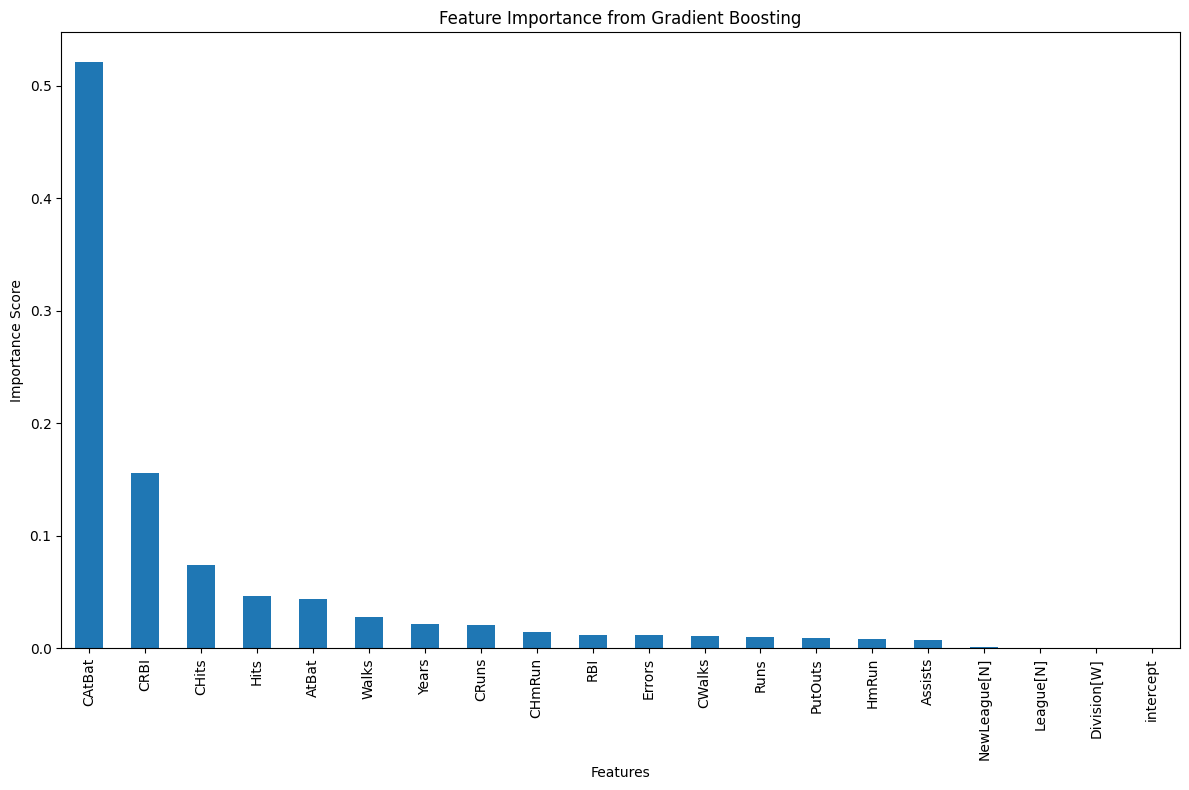

In [26]:
importance = best_GBR.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

Bagging RSS : 0.0013334476269294035


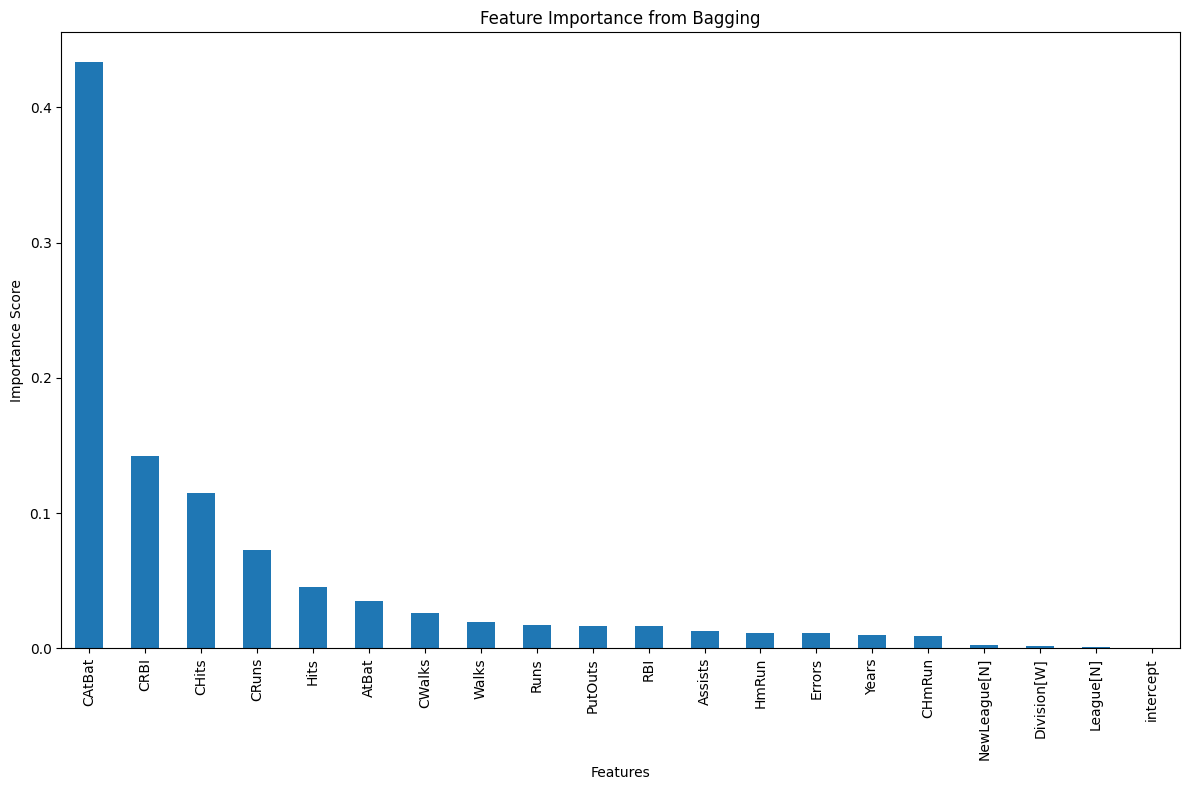

In [32]:
# Bagging
bag = RF(n_estimators=1000, max_features=x.shape[1], random_state=0)
bag.fit(x_train, y_train)
y_pred = bag.predict(x_test)
rss = np.mean((y_pred - y_test) ** 2)
print(f"Bagging RSS : {rss}")

# Feature Importance
importance = bag.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Bagging')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

Wow Bagging and Boosting are almost same and there feature importance scores are also almost same. Dammmmm sick algorithmns

### Question 11

In [35]:
data = load_data('Caravan')
data.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [60]:
x = data.drop(columns='Purchase')
y = data['Purchase']
y = np.where(y == "Yes", 1, 0)

# Division
cv = skm.ShuffleSplit(n_splits = 1, test_size = 0.3, random_state=0)
train_idx, test_idx = next(cv.split(x))
x_train, y_train = x.iloc[train_idx], y[train_idx]
y_test = y[test_idx]
x_test = x.iloc[test_idx]



In [61]:
boost = GBR(n_estimators=1000, learning_rate=0.01, random_state=0)
boost.fit(x_train, y_train)
y_pred = boost.predict(x_test)

In [65]:
y_pred = np.where(y_pred > 0.2, 1, 0)
confusion = confusion_table(y_test, y_pred)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Log Loss : {log_loss(y_test, y_pred)}")

confusion

Accuracy : 0.909559244419004
Log Loss : 3.259815246411282


Truth,0,1
Predicted,,
0,1574,65
1,93,15


Suffers from high specificity and sensitivity i.e. false positives and negatives are high and the data is structured in such a manner where more than 90% of the dataset is not purchasing so the benchmark should be random sample of whether the purchase happens or not.

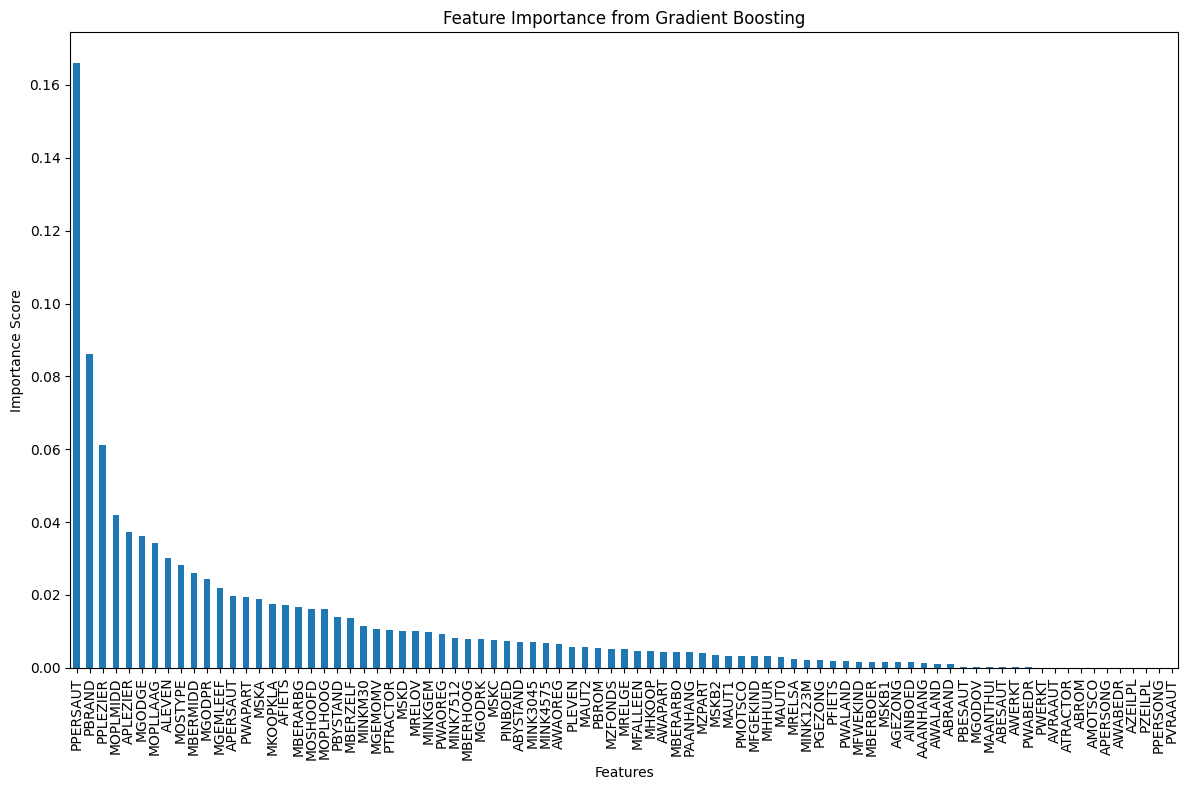

In [82]:
importance = boost.feature_importances_
importance = pd.Series(importance, index=x.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importance.plot(kind='bar')
plt.title('Feature Importance from Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


In [68]:
# Logistic Regression

logit = sm.GLM(y_train, x_train, family=sm.families.Binomial()).fit()
y_pred = logit.predict(x_test)
y_pred = np.where(y_pred > 0.2, 1, 0)
confusion = confusion_table(y_test, y_pred)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Log Loss : {log_loss(y_test, y_pred)}")

Accuracy : 0.9101316542644533
Log Loss : 3.2391835043453883


In [83]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
confusion = confusion_table(y_test, y_pred)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Log Loss : {log_loss(y_test, y_pred)}")

Accuracy : 0.9341728677733258
Log Loss : 2.372650337577832


In [81]:
data["Purchase"].value_counts() / data.shape[0]

Purchase
No     0.940227
Yes    0.059773
Name: count, dtype: float64

Even we take a random sample then around 94% of the people are not going to purchase and with the algorithmns with have, boosting predicts around 90% correctly, Logistic regression does around 91% and KNN around 93.5%. 

Here i don't see any value in using the algorithmns because they are not useful to be honest or better than a random guess.

Lesson : Data Quality is very important.